![CH5-ADS.png](.\Media\CH5-ADS.png)
# <span style="color:#cc5500;">Simple Restore Techniques</span>

The BACKUP Database command backs up a complete SQL Server database to create a database backup, or one or more files or filegroups of the database to create a file backup (BACKUP DATABASE).  Also, under the full recovery model or bulk-logged recovery model, backs up the transaction log of the database to create a log backup (BACKUP LOG).

## <span style="color:#cc5500;">Recovering a Corrupt database from Backups</span>

While Restoring a corrupt database from a know-good backup set is the best way to avoid data loss, it’s not necessarily the best way to avoid downtime.  It depends what kind of backups are available.  For example, with a backup strategy of full backup every Sunday and half-hourly transaction log backups:

- If recovery is necessary towards the end of the week, lots of log backups will need to be restored, which will take a long time and some handy TSQL scripts
- It is likely better to have daily full or differential backups to allow faster restore

Remember:  Backups have to exist to be useful.  Backups have to be valid to avoid data loss

How often do you validate your backups?  It is recommended that you perform a full test restore on another server at least once a week.

## <span style="color:#cc5500;">Backup Types</span>

The BACKUP Database statements are here: [BACKUP (Transact-SQL) - SQL Server | Microsoft Docs](https://docs.microsoft.com/en-us/sql/t-sql/statements/backup-transact-sql?view=sql-server-ver15)  There are more advanced nuances to the types listed below, but the basics will be covered in this notebook.

- Full database backup
    - The starting point for any restore sequence is usually the most recent full database backup
    - This provides a single point in time to restore to, or the basis for further restore operations
- Transaction log backup
    - Commonly known as just a “log backup”
    - The set of transaction log records generated since the last log backup completed, using the full or bulk\_loggedrecovery models
    - Must be used to roll forward a database to the desired point in time
- Differential database backup
    - The set of data file pages that have changed since the most recent full database backup preceding this backup
    - A differential backup is the net effect of all transaction log backups between the most recent full backup and this differential backup
    - Where possible, the restore sequence will start with restoring a full backup and then restore the most recent differential backup, before finishing with transaction log backups
    - This makes the restore sequence shorter and faster
- There are also full file, full filegroup, differential file , and differential filegroup backups
    - Their use is more advanced and we will not consider them here
    - If they exist in your environment, it is imperative that you practice restore sequences with them

## <span style="color:#cc5500;">How to Restore</span>

In an emergency, always go to you operations guide, DR handbook, or run book.  Do you have one?  If not, this should be a high priority.

- The Operations guide should define:
    - Location of backups
    - How to put together the restore sequence, depending on what is damaged
    - Commands or scripts to use
    - Amount of time expected per step during restore process
- There may be a 3rd-party backup/restore tool that you must use.  If so, it is important to master those skills
    - In this Notebook, we are just covering SQL Server native backups
- Make sure to use the correct RESTORE options
    - Covered in this notebook

## <span style="color:#cc5500;">Continuity of the Log Backup Chain</span>

The log backup chain is an unbroken sequence of transaction log backups covering the time between the most recent full backup, and the point in time to which a restore is required (typically the current time, but not always).  If the transaction log backup chain is not complete (meaning one or more log backups are damaged or missing in your sequence of transaction log backups) then complete recovery is not possible unless the “gap” can be bridged with a differential backup.  [Transaction Log Backups (SQL Server) - SQL Server | Microsoft Docs](https://docs.microsoft.com/en-us/sql/relational-databases/backup-restore/transaction-log-backups-sql-server?view=sql-server-ver15)

- Consider creating copies of all backups, with some stored off-site
- What breaks the log chain?
    - Deleting or missing or damaging one of your transaction log backups
    - Clearing the transaction log manually
        - Using the WITH TRUNCATE\_ONLY or WITH NO\_LOG options on BACKUP LOG with versions prior to SQL Server 2008
    - Changing the database to the simple recovery model
    - Reverting from a database snapshot or rebuilding the transaction log

Here's a helpful wiki: [Various Causes of Log Chains Breaking Issue in SQL Server - TechNet Articles - United States (English) - TechNet Wiki (microsoft.com)](https://social.technet.microsoft.com/wiki/contents/articles/25439.various-causes-of-log-chains-breaking-issue-in-sql-server.aspx)

## <span style="color:#cc5500;">Restore Options</span>

This command enables you to perform the following restore scenarios:  [RESTORE (Transact-SQL) - SQL Server | Microsoft Docs](https://docs.microsoft.com/en-us/sql/t-sql/statements/restore-statements-transact-sql?view=sql-server-ver15)

- Restore an entire database from a full database backup (a complete restore).
- Restore part of a database (a partial restore).
- Restore specific files or filegroups to a database (a file restore).
- Restore specific pages to a database (a page restore).
- Restore a transaction log onto a database (a transaction log restore).
- Revert a database to the point in time captured by a database snapshot.

Just like stated above regarding BACKUP, there are also some advanced nuances to RESTORE and the basics will be covered in this Notebook.

- WITH RECOVERY is the default
    - Does not allow further restore options as database is fully recovered
    - Frustrating for some, if they forget to specify NORECOVERY, then their database will recover, and then you will have to start over again
- Use WITH NORECOVERY for safety and make it your default for all restore operations in the restore sequence
    - Postpones fully recovering the database
    - Then use RESTORE DATABASE dbname WITH RECOVERY to complete the restore sequence
    - If you make a mistake, you must restart the restore sequence
- WITH STANDBY is the same as WITH NORECOVERY but creates a recovered, read-only database for you to look in
    - Creates an UNDO file to save info from transactions that are pending at the end of the restore

## <span style="color:#cc5500;">Restore a database to a specific point in time</span>

What if you know when the corruption occured and you want to restore your database to a point in time?

- Common examples:
    - Restore a database to the time just before a user or application error occurred (e.g. dropping a table)
    - Restore a database to the point before a known corruption-causing event occurred
- Start with most recent full backup and proceed with smallest set of backups to the desired point
- Best practice is to use WITH STOPAT on all operations in the restore sequence
    - Date and time specific, or
    - Transaction name (i.e. marked transaction)
    - Note: All work after the stop point is lost

## <span style="color:#cc5500;">Demo:  Point in Time Recovery</span>

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set

In [ ]:
-- Create a test database for this demo
USE [master];
GO

IF DATABASEPROPERTYEX (N'Company', N'Version') > 0
BEGIN
	ALTER DATABASE [Company] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [Company];
END
GO

-- Create the database
CREATE DATABASE [Company] ON PRIMARY (
    NAME = N'Company',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company.mdf')  -- Modify path for your environment
LOG ON (
    NAME = N'Company_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_log.ldf');  -- Modify path for your environment
GO


In [ ]:
-- Here we create a table, load 1 random record and then take a backup

USE [Company];
GO

-- Create a table
CREATE TABLE [RandomData] (
	[c1] INT IDENTITY,
	[c2] VARCHAR (100));
GO

INSERT INTO [RandomData] VALUES
	('Initial data: transaction 1');
GO

-- And take a full backup
BACKUP DATABASE [Company]
TO DISK = N'C:\Temp\Backups\Company_Full.bak'  -- Modify path for your environment
WITH INIT;
GO


In [ ]:
-- Here we create two seperate insert operations and our first log backup
INSERT INTO [RandomData] VALUES
	('Transaction 2');
INSERT INTO [RandomData] VALUES
	('Transaction 3');
GO

BACKUP LOG [Company]
TO DISK = N'C:\Temp\Backups\Company_Log1.bak'  -- Modify path for your environment
WITH INIT;
GO

In [ ]:
-- And two more records
INSERT INTO [RandomData] VALUES
	('Transaction 4');
INSERT INTO [RandomData] VALUES
	('Transaction 5');
GO

In [ ]:
-- Now, we need create a notional point in time to rocover to.  Run this GETDATE and paste the results into notepad
SELECT GETDATE ();
GO

In [ ]:
-- And two more updates and then take another log backup
INSERT INTO [RandomData] VALUES
	('Transaction 6');
INSERT INTO [RandomData] VALUES
	('Transaction 7');
GO

-- And take another backup
BACKUP LOG [Company]
TO DISK = N'C:\Temp\Backups\Company_Log2.bak' -- Modify path for your environment
WITH INIT;
GO

Now we are going to simulate a disaster, by deleting the database.  You'd be amazed at how many times customers have called Microsoft for help after accidentially deleting a database.

In [ ]:
-- Simulate corruption that destroys the database
USE [master];
GO

DROP DATABASE [Company];
GO


The database is now gone.  But, the good news is we have backups, and will now demonstrate a point in time recovery.

In [ ]:
-- We have three backups - so restore them
-- Restore the full backup and the logs
RESTORE DATABASE [Company]
FROM DISK = N'C:\Temp\Backups\Company_Full.bak'  -- Modify path for your environment
WITH REPLACE;
GO

-- And the log backups
RESTORE LOG [Company]
FROM DISK = N'C:\Temp\Backups\Company_Log1.bak'  -- Modify path for your environment

RESTORE LOG [Company]
FROM DISK = N'C:\Temp\Backups\Company_Log2.bak'  -- Modify path for your environment
GO

Why did the transaction log restore fail?  Remember from the notes above, WITH RECOVERY is the default behavior if not specified.  So, the RESTORE DATABASE operation went in to Recovery, then we tried to restore a log to a recovered database.  That is not allowed.  So we have to start over again and use NO RECOVERY.

In [ ]:
-- We need to start again... restore the database, then both logs, the select from the table to see if we are good and have all 7 records.
RESTORE DATABASE [Company]
FROM DISK = N'C:\Temp\Backups\Company_Full.bak'  -- Modify path for your environment
WITH REPLACE, NORECOVERY;
GO

-- And the log backups
RESTORE LOG [Company]
FROM DISK = N'C:\Temp\Backups\Company_Log1.bak'  -- Modify path for your environment
WITH NORECOVERY;

RESTORE LOG [Company]
FROM DISK = N'C:\Temp\Backups\Company_Log2.bak'  -- Modify path for your environment
WITH NORECOVERY;
GO

-- And then finalize recovery
RESTORE DATABASE [Company] WITH RECOVERY;
GO

SELECT * FROM [Company].[dbo].[RandomData];
GO

What if we woul like to examine our data bewtween restored.

We will do this by means of STANDBY

In [ ]:
-- What if we want to examine things between restores?
-- Here we will use standy by and see if the databases is accessible in standby mode
RESTORE DATABASE [Company]
FROM DISK = N'C:\Temp\Backups\Company_Full.bak'  -- Modify path for your environment
WITH REPLACE, STANDBY = N'C:\Temp\Backups\standbyfile.dat';  -- Modify path for your environment
GO

-- We can see what's in there...
SELECT * FROM [Company].[dbo].[RandomData];
GO


Yes, you can select data from that table and if you look at SSMS, you will see that database is in standby / read only

  ![CH5-Standby.jpg](.\Media\CH5-Standby.jpg)

Now, can you update a database in Standby and; insert a new record?

In [ ]:
-- Can we update anything?
INSERT INTO [Company].[dbo].[RandomData] VALUES
	('Transaction 8');
GO

No, you can not update a database in Standby

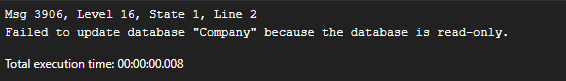

What if we want to RESTORE to a specific time?  We will now restore this database to the point in time (from when you did the GETDATE() above).  Hopefully you still have that saved in notepad.

In [ ]:
-- What if we want to stop at a specific point?  We will restore from full, restore from log 1, and create a standby file, then restore to our point in time
RESTORE DATABASE [Company]
FROM DISK = N'C:\Temp\Backups\Company_Full.bak'  -- Modify path for your environment
WITH REPLACE, NORECOVERY
GO

RESTORE LOG [Company]
FROM DISK = N'C:\Temp\Backups\Company_Log1.bak'  -- Modify path for your environment
WITH STANDBY = N'C:\Temp\Backups\standbyfile.dat', -- Modify path for your environment
STOPAT = '2022-01-13 12:38:28.510'
GO

-- Are we there yet?
SELECT * FROM [Company].[dbo].[RandomData];
GO

No were are not there yet.  This message is telling us that the STOPAT time we entered is not in log backup 1.....but is in a later log backup

  ![CH5-STOPAT-Miss.jpg](.\Media\CH5-STOPAT-Miss.jpg)

Our STOPAT time is located in the next log backup.  So let's do that now.  Remember, we are in standby again, so we can just apply log backup 2 with out having to start from the beginning.  We will keep it in Standby

In [ ]:
RESTORE LOG [Company]
FROM DISK = N'C:\Temp\Backups\Company_Log2.bak'  -- Modify path for your environment
WITH STANDBY = N'C:\Temp\Backups\standbyfile.dat', -- Modify path for your environment
STOPAT = '2022-01-13 12:38:28.510';
GO

-- Is this the right point?
SELECT * FROM [Company].[dbo].[RandomData];
GO

In [ ]:
-- Okay, time to finalize recovery.  Select our data.
RESTORE DATABASE [Company] WITH RECOVERY;
GO
SELECT * FROM [Company].[dbo].[RandomData];
GO

-- Best Practice.  We will also want to take another full backup so we don't need to go through all that again.  We spent a lot of time getting our database to the exact
-- point in time, just prior to the corruption, and we dont want to have to repeat this again from the beginning.
BACKUP DATABASE [Company]
TO DISK = N'C:\Temp\Backups\Company_NewFull.bak'  --Modify path for your environment
WITH INIT;
GO


## <span style="color:#cc5500;">Tail of the Log Backups</span>

After a disaster, where it is necessary to restore from backups, the final portion of the transaction log must first be backed up to allow restoration with zero data loss,  A tail-log backup captures any log records that have not yet been backed up (the tail of the log) to prevent work loss and to keep the log chain intact.  Before you can recover a SQL Server database to its latest point in time, you must back up the tail of its transaction log. The tail-log backup will be the last backup of interest in the recovery plan for the database.  Not all restore scenarios require a tail-log backup. You do not need a tail-log backup if the recovery point is contained in an earlier log backup.

We recommend that you take a tail-log backup in the following scenarios:

- If the database is <span style="color:#e32636;">online</span> and you plan to perform a restore operation on the database, begin by backing up the tail of the log. To avoid an error for an online database, you must use the ... WITH NORECOVERY option of the BACKUP Transact-SQL statement.
- If a database is <span style="color:#e32636;">offline</span> and fails to start and you need to restore the database, first back up the tail of the log. Because no transactions can occur at this time, using the WITH NORECOVERY is optional.
- If a database is <span style="color:#e32636;">damaged</span>, try to take a tail-log backup by using the WITH CONTINUE\_AFTER\_ERROR option of the BACKUP statement.
- On a <span style="color:#e32636;">damaged</span> database backing up the tail of the log can succeed only if the log files are undamaged, the database is in a state that supports tail-log backups, and the database does not contain any bulk-logged changes. If a tail-log backup cannot be created, any transactions committed after the latest log backup are lost.

## <span style="color:#cc5500;">Demo:  Tail of the log backup</span>

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set

In [ ]:
-- Create a test database for this demo
USE [master];
GO

IF DATABASEPROPERTYEX (N'Company', N'Version') > 0
BEGIN
	ALTER DATABASE [Company] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [Company];
END
GO

-- Create the database
CREATE DATABASE [Company] ON PRIMARY (
    NAME = N'Company',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company.mdf')  -- Modify path for your environment
LOG ON (
    NAME = N'Company_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_log.ldf');  -- Modify path for your environment
GO


In [ ]:
-- Here we create a table, load 1 random record and then take a backup

USE [Company];
GO

-- Create a table
CREATE TABLE [RandomData] (
	[c1] INT IDENTITY,
	[c2] VARCHAR (100));
GO

INSERT INTO [RandomData] VALUES
	('Initial data: transaction 1');
GO

-- And take a full backup
BACKUP DATABASE [Company]
TO DISK = N'C:\Temp\Backups\Company_Full.bak'  -- Modify path for your environment
WITH INIT;
GO

In [ ]:
-- Here we create two seperate insert operations and our first log backup
INSERT INTO [RandomData] VALUES
	('Transaction 2');
INSERT INTO [RandomData] VALUES
	('Transaction 3');
GO

BACKUP LOG [Company]
TO DISK = N'C:\Temp\Backups\Company_Log1.bak'  -- Modify path for your environment
WITH INIT;
GO

In [ ]:
-- And two more records
INSERT INTO [RandomData] VALUES
	('Transaction 4');
INSERT INTO [RandomData] VALUES
	('Transaction 5');
GO

In [ ]:
-- Here we Simulate a crash
ALTER DATABASE [Company] SET OFFLINE;
GO


Now that the database is offline.  

![CH5-Offline.jpg](.\Media\CH5-Offline.jpg)

Navigate to the location of your database files.  In my case it is:

<span style="white-space: pre; color: rgb(206, 145, 120);">C:\Program&nbsp;Files\Microsoft&nbsp;SQL&nbsp;Server\MSSQL14.VIPER\MSSQL\DATA</span>

Delete the .mdf file for the test Company Database

![CH5-Delete-MDF.jpg](.\Media\CH5-Delete-MDF.jpg)

In [ ]:
-- Try to bring the database online
ALTER DATABASE [Company] SET ONLINE;
GO

You can't bring it online because your database is missing its' data file

![CH5-Recovery-Pending.jpg](.\Media\CH5-Recovery-Pending.jpg)

In [ ]:
-- The backups we have don't have the most recent transactions, so if we restore the backups we'll lose those transactions.  Remember we added records 4 and 5 after the log backup.
-- We will restore a "COPY" of the Company Database so we use a different name, as the Company database (original is still visible but crashed in SSMS)

-- Let's see...
RESTORE DATABASE [Company_Copy]
FROM DISK = N'C:\Temp\Backups\Company_Full.bak'   -- Modify path for your environment
WITH
    MOVE N'Company' TO N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_Copy.mdf',  -- Modify path for your environment
	MOVE N'Company_log' TO N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_Copy_log.ldf', -- Modify path for your environment
	REPLACE, NORECOVERY;
GO

RESTORE LOG [Company_Copy]
FROM DISK = N'C:\Temp\Backups\Company_Log1.bak' -- Modify path for your environment
WITH NORECOVERY;
GO

RESTORE DATABASE [Company_Copy] WITH RECOVERY;
GO

-- What data do we have?
SELECT * FROM [Company_Copy].[dbo].[RandomData];
GO


We are missing records # 5 and 6.  They are still in the active transaction log file.  True the data file was deleted, but we still have the original log file in-tact.

Let's see if we can do a standard transaction log backup of the original Company database to grab the tail.

Can we do it?

In [ ]:
-- Take a log backup?  We'll call it _Log_Tail.bak
BACKUP LOG [Company]
TO DISK = N'C:\Temp\Backups\Company_Log_Tail.bak' -- Modify path for your environment
WITH INIT;
GO

No we can't.  It throws an error.  It has an inaccessible data file.  We deleted it.

What do we do now?  We use a more advanced option called NO\_TRUNCATE.

Avoid using NO\_TRUNCATE, <span style="color:#e32636;">except when the database is damaged.</span> Ours is damaged.  After the restore, set the database back to multi-user mode.

In [ ]:
-- Let's do our tail of the log backup with the special syntax!
BACKUP LOG [Company]
TO DISK = N'C:\Temp\Backups\Company_Log_Tail.bak' -- Modify path for your environment
WITH INIT, NO_TRUNCATE;
GO

In [ ]:
-- Now let's wrap this up, get our data from a restore
RESTORE DATABASE [Company_Copy]
FROM DISK = N'C:\Temp\Backups\Company_Full.bak'   -- Modify path for your environment
WITH
    MOVE N'Company' TO N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_Copy.mdf',  -- Modify path for your environment
	MOVE N'Company_log' TO N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_Copy_log.ldf', -- Modify path for your environment
	REPLACE, NORECOVERY;
GO

RESTORE LOG [Company_Copy]
FROM DISK = N'C:\Temp\Backups\Company_Log1.bak'  -- Modify path for your environment
WITH NORECOVERY;
GO

RESTORE LOG [Company_Copy]
FROM DISK = N'C:\Temp\Backups\Company_Log_Tail.bak' -- Let's get that tail.  Modify path for your environment
WITH NORECOVERY;
GO

RESTORE DATABASE [Company_Copy] WITH RECOVERY;
GO

-- Is everything there?  Yes!
SELECT * FROM [Company_Copy].[dbo].[RandomData];
GO


So we just completed a zero-data-loss recovery from a damaged database!

## <span style="color:#cc5500;">Recovering with Full, Differential, and Log Backups</span>

![CH5-Backup-Sequence.jpg](.\Media\CH5-Backup-Sequence.jpg)

![CH5-Diff-3.jpg](.\Media\CH5-Diff-3.jpg)